Defining machine learning models using numerical computation building blocks
1. Linear regression
2. Logistic regression

Customizing machine learning models

In [19]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt 
rng = np.random

## Linear Regression 

Specification of the model:
$y$ = $b$ + $w_1$$x_1$ + ... +  $w_p$$x_p$
- $y$ is the regressed variable
- $w$'s are the weights
- $b$ is the bias term
- $x$'s are the features used to model y

In [13]:
# Some toy data
train_X = np.asarray([3.3,4.4,5.5,6.71,6.93,4.168,9.779,6.182,7.59,2.167,
                         7.042,10.791,5.313,7.997,5.654,9.27,3.1])
train_Y = np.asarray([1.7,2.76,2.09,3.19,1.694,1.573,3.366,2.596,2.53,1.221,
                         2.827,3.465,1.65,2.904,2.42,2.94,1.3])
n_samples = train_X.shape[0]

New concepts:
1. Placeholders: https://www.tensorflow.org/api_guides/python/io_ops#Placeholders
2. Variables: https://www.tensorflow.org/programmers_guide/variables

In [10]:
# Defining the computational graph for linear regression with 1 explanatory variable
# p = 1

# Input to the graph
y = tf.placeholder(dtype = tf.float32) # Placeholders - https://www.tensorflow.org/api_guides/python/io_ops#Placeholders
x = tf.placeholder(dtype = tf.float32)

# Model parameters are defined using variables
# Variables - https://www.tensorflow.org/programmers_guide/variables
# Variables retain their value even outside the bounds of a session's run call
w = tf.Variable(initial_value = rng.randn(), name = "weight") 
b = tf.Variable(initial_value = rng.randn(), name = "bias")

# Connecting up the nodes in our linear model
# y = b + Wx

prediction = tf.add(b, tf.multiply(w, x))

# prediction holds the tensor that is the output of the operation add which takes tensors b, and the output of the multiply operation between the weight w, and the input x

Our model is complete, but our computational graph is not yet complete. To complete the computational graph, we need to define a loss function and an optimization strategy to allow for the training of the free variables, $b$ and $w$ 

New concepts:
3. reduce_sum operation: https://www.tensorflow.org/api_docs/python/tf/reduce_sum
4. Gradient descent optimizer: https://www.tensorflow.org/api_docs/python/tf/train/GradientDescentOptimizer

In [15]:
# Defining loss for our model
# Loss is the mean squared error between actual $y$ and predicted $y$

loss = tf.reduce_sum( input_tensor = tf.pow(prediction-y, 2))/(2*n_samples)
# reduce_sum is a function to compute the sum across dimensions of a tensor. In this case, the input tensor is a 1 x n_samples dimensional tensor of the prediction errors corresponding to the training samples  
# https://www.tensorflow.org/api_docs/python/tf/reduce_sum

# We can use gradient descent to train our linear model
# https://www.tensorflow.org/api_docs/python/tf/train/GradientDescentOptimizer
learning_rate = 0.01
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

We now have a complete computational graph. Each run of the optimizer takes one sample of X and Y as input, makes a prediction. The optimizer updates the free variables in its loss function based on the prediction for that input.

In [16]:
# We also need an operation to initialize our global  (w and b)
init = init = tf.global_variables_initializer()

Epoch: 0050 loss= 0.079028860 W= 0.2246135 b= 0.9811713
Epoch: 0100 loss= 0.078795709 W= 0.22609936 b= 0.9704826
Epoch: 0150 loss= 0.078589350 W= 0.22749679 b= 0.9604295
Epoch: 0200 loss= 0.078406684 W= 0.22881103 b= 0.95097494
Epoch: 0250 loss= 0.078245007 W= 0.23004703 b= 0.94208294
Epoch: 0300 loss= 0.078101903 W= 0.23120938 b= 0.93372124
Epoch: 0350 loss= 0.077975221 W= 0.23230262 b= 0.9258566
Epoch: 0400 loss= 0.077863067 W= 0.23333083 b= 0.9184592
Epoch: 0450 loss= 0.077763751 W= 0.234298 b= 0.9115017
Epoch: 0500 loss= 0.077675819 W= 0.23520775 b= 0.9049575
Epoch: 0550 loss= 0.077597961 W= 0.23606326 b= 0.8988027
Epoch: 0600 loss= 0.077529006 W= 0.23686789 b= 0.89301443
Epoch: 0650 loss= 0.077467956 W= 0.23762469 b= 0.8875697
Epoch: 0700 loss= 0.077413879 W= 0.23833655 b= 0.8824489
Epoch: 0750 loss= 0.077365980 W= 0.23900597 b= 0.8776329
Epoch: 0800 loss= 0.077323578 W= 0.23963557 b= 0.8731038
Epoch: 0850 loss= 0.077285990 W= 0.24022782 b= 0.8688434
Epoch: 0900 loss= 0.077252731 

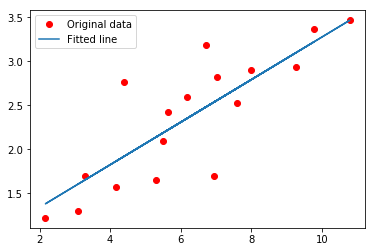

In [23]:
# We can now run the computational graph in a session
training_epochs = 1000                      # We will run our model 1000 times
display_step = 50                 # Display the loss every 50 runs
with tf.Session() as sess:
    sess.run(init)

    # Fit all training data
    for epoch in range(training_epochs):
        for (sample_x, sample_y) in zip(train_X, train_Y):
            sess.run(optimizer, feed_dict={x: sample_x, y: sample_y})

        #Display logs per epoch step
        if (epoch+1) % display_step == 0:
            c = sess.run(loss, feed_dict={x: train_X, y:train_Y})
            print("Epoch:", '%04d' % (epoch+1), "loss=", "{:.9f}".format(c), \
                "W=", sess.run(w), "b=", sess.run(b))

    print("Optimization Finished!")
    training_loss = sess.run(loss, feed_dict={x: train_X, y:train_Y})
    print("Training loss=", training_loss, "w=", sess.run(w), "b=", sess.run(b), '\n')

    #Graphic display
    plt.plot(train_X, train_Y, 'ro', label='Original data')
    plt.plot(train_X, sess.run(w) * train_X + sess.run(b), label='Fitted line')
    plt.legend()
    plt.show()

## Logistic Regression 

We can create a logistic regressor in a similar fashion as to how we created a linear regression computational graph.

We will use the MNIST database of <a href=http://yann.lecun.com/exdb/mnist/>handwritten digits</a> for this example.

In [24]:
# Import MINST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


Logistic regression model specification:

$y$ = $g$($\Theta^{T}$ $X$) = $g$($\sum_{i=0}^{n}$ $\theta_{i}$ $x_{i}$) $\text{ where }$ $x_0$ = 1

- g is the <a href = https://en.wikipedia.org/wiki/Softmax_function>softmax function</a> which squashes any input to the 0-1 range

- Tensorflow provides an implementation of the softmax function, which we can use.

- The logistic regression model is trained by minimizing a cross-entropy loss.

New concepts:
5. Softmax : https://www.tensorflow.org/api_docs/python/tf/nn/softmax
6. Reduce_mean : https://www.tensorflow.org/api_docs/python/tf/reduce_mean

In [37]:
# Specifying the model
# tf Graph Input
x = tf.placeholder(dtype = tf.float32, shape = [None, 784]) # mnist data image of shape 28*28=784
y = tf.placeholder(dtype = tf.float32, shape = [None, 10]) # 0-9 digits recognition => 10 classes

# Set model weights
W = tf.Variable(initial_value = tf.zeros([784, 10]))
b = tf.Variable(initial_value = tf.zeros([10]))

# Construct model
prediction = tf.nn.softmax(tf.add(b, tf.matmul(x, W))) # Softmax

# Minimize error using cross entropy loss
# reduce_mean calculates the mean across dimensions of a tensor
loss = tf.reduce_mean(-tf.reduce_sum(y*tf.log(prediction), axis=1))

# Gradient Descent
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

In [38]:
# Parameters
learning_rate = 0.01
training_epochs = 25
batch_size = 100
display_step = 1

In [ ]:
# Start training
with tf.Session() as sess:
    sess.run(init)

    # Training cycle
    for epoch in range(training_epochs):
        avg_loss = 0.
        total_batch = int(mnist.train.num_examples/batch_size)
        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            # Fit training using batch data
            _, c = sess.run([optimizer, loss], feed_dict={x: batch_xs,
                                                          y: batch_ys})
            # Compute average loss
            avg_cost += c / total_batch
        # Display logs per epoch step
        if (epoch+1) % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "loss=", "{:.9f}".format(avg_loss))

    print("Optimization Finished!")

    # Test model
    correct_prediction = tf.equal(tf.argmax(prediction, 1), tf.argmax(y, 1))
    # Calculate accuracy for 3000 examples
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy:", accuracy.eval({x: mnist.test.images[:3000], y: mnist.test.labels[:3000]}))

Epoch: 0001 loss= 0.000000000
Epoch: 0002 loss= 0.000000000
Epoch: 0003 loss= 0.000000000
Epoch: 0004 loss= 0.000000000
Epoch: 0005 loss= 0.000000000
Epoch: 0006 loss= 0.000000000
Epoch: 0007 loss= 0.000000000
Epoch: 0008 loss= 0.000000000
